In [1]:

import numpy as np 
import pandas as pd 

import os



In [2]:
import torch
import torchvision 
from torchvision.transforms import ToTensor
import torchvision.transforms as TT
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [4]:
train_dir="/kaggle/input/tomato-disease-multiple-sources/train"
val_dir='/kaggle/input/tomato-disease-multiple-sources/valid'

In [5]:
Bacterial_spot_files = os.listdir(train_dir + "/Bacterial_spot")
print('No. of training examples for Bacterial_spot:', len(Bacterial_spot_files))
print(Bacterial_spot_files[:5])

No. of training examples for Bacterial_spot: 2826
['a129e8eb-e2b4-4a8a-a509-f6625da6b11c___GCREC_Bact.Sp 3002.JPG', '21833eb1-b84e-4471-816b-166e575ed0e7___GCREC_Bact.Sp 3244.JPG', 'Bs102_lower.jpg', '67c8bbdb-ba79-4c64-897f-e9052728df45___GCREC_Bact.Sp 3008.JPG', 'Bs18_hight.jpg']


In [6]:
Early_blight_files = os.listdir(train_dir + "/Early_blight")
print('No. of training examples for Early_blight:', len(Early_blight_files))
print(Early_blight_files[:5])

No. of training examples for Early_blight: 2455
['e56354a5-5e3f-4ed6-bfe5-3c783a32dc98___RS_Erly.B 9413_flipTB.JPG', 'cf8c6e28-201c-4c8e-994f-8dcf98362e64___RS_Erly.B 7651.JPG', 'earlyblighttomato_jpg.rf.054c03fcd1e1f3d929077fcf134d72a4.jpg', 'tomato-early-blightH_jpg.rf.ca3c93337e713a4020c52e79e6345087.jpg', 'e11ee1f8-8de2-4d9c-a0c1-86bc42350fd9___RS_Erly.B 9472.JPG']


In [7]:
tfms = TT.Compose([TT.Resize((32, 32)),TT.ToTensor()])

In [8]:
train_ds=ImageFolder(train_dir,transform=tfms)
val_ds=ImageFolder(val_dir,transform=tfms)


In [9]:
train_ds

Dataset ImageFolder
    Number of datapoints: 25851
    Root location: /kaggle/input/tomato-disease-multiple-sources/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

torch.Size([3, 32, 32])


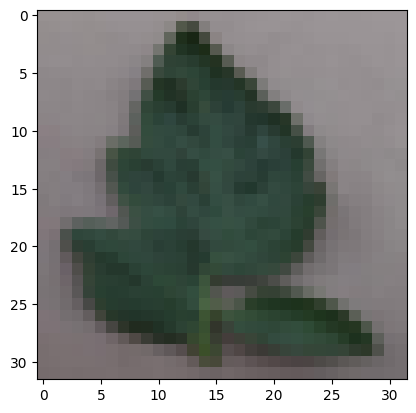

In [10]:
image,label = train_ds[0]
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [11]:
train_dl=DataLoader(train_ds,batch_size=24,shuffle=True,num_workers=3,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=24,num_workers=3,pin_memory=True)

In [12]:
len(train_dl),len(val_dl)

(1078, 279)

In [13]:
def show_batch(dl):
    for image,label in dl:
        fig,ax=plt.subplots(figsize=(16,16))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(image,nrow=8).permute(1,2,0))
        break

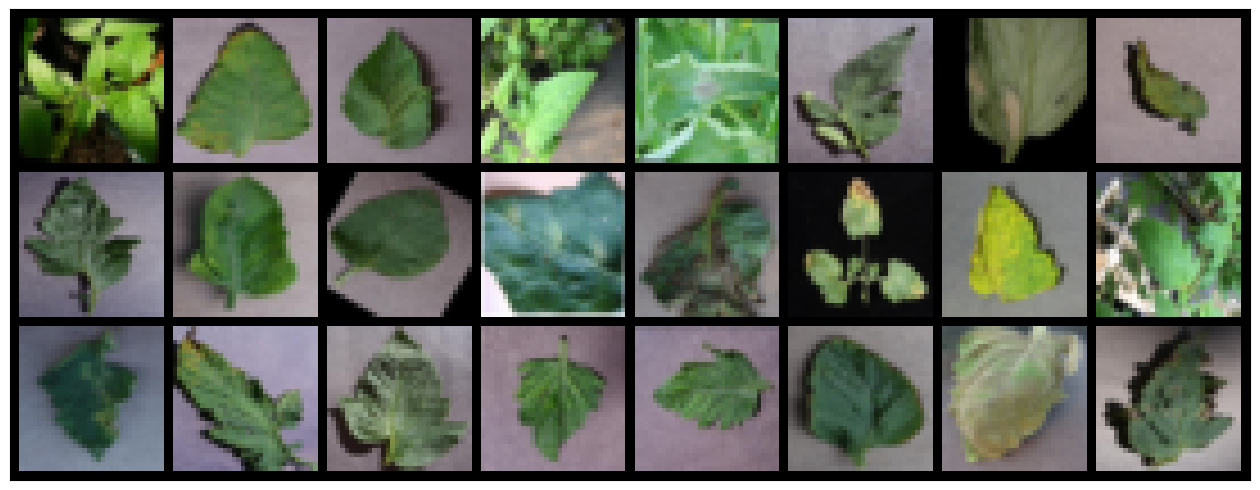

In [14]:
show_batch(train_dl)

In [15]:
def accuracy(output,label):
    _,pred=torch.max(output,dim=1)
    return torch.tensor(torch.sum(pred==label).item()/len(pred))


class ImageClassifierBase(nn.Module):
    def training_step(self,batch):
        image,label=batch
        pred=self(image)
        loss=F.cross_entropy(pred,label)
        return loss
    def validation_step(self,batch):
       image,label=batch
       pred,label=batch
       pred=self(image)
       val_loss=F.cross_entropy(pred,label)
       val_acc=accuracy(pred,label)
       return {'val_loss':val_loss,'val_acc':val_acc}

    def validation_epoch_end(self,output):
       batch_loss=[x['val_loss'] for x in output]
       epoch_loss=torch.stack(batch_loss).mean()
       batch_acc=[x['val_acc'] for x in output]
       epoch_acc=torch.stack(batch_acc).mean()
       return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
        
    @torch.no_grad()
    def evaluate(self, val_loader):
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(outputs)


In [16]:
from torchvision import models

class LeafDisease(ImageClassifierBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        self.network=models.resnet34(pretrained=pretrained)
        self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)

    def forward(self,xb):
       return self.network(xb)
    

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
       for b in self.dl:
           yield to_device(b,self.device)

    def __len__(self):
       return len(self.dl)

In [18]:
device=get_default_device()
device

device(type='cuda')

In [19]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [20]:
from tqdm.notebook import tqdm

def fit(num_epochs,lr,model,train_dl,val_dl,opt_f=torch.optim.SGD):

    opt=opt_f(model.parameters().lr)
    history=[]

    for epoch in range(num_epoch):
        model.train()
        train_losses=[]

        for batch in tqdm(train_dl):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
        result=model.evaluate(val_dl)
        result['train_loss']=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return result
            

In [21]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
        

In [22]:
def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                 weight_decay=0,grad_clip=None,
                 opt_func=torch.optim.SGD):

    opt=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr,epochs=epochs,
                                             steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses=[]
        lrs=[]

        for batch in tqdm(train_dl):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),
                                         grad_clip)
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            sched.step()
        result=model.evaluate(val_dl)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

        

In [23]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [24]:
model=LeafDisease(len(train_ds.classes))
to_device(model,device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s] 


LeafDisease(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
train_ds.classes

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [26]:
history = [model.evaluate(val_dl)]


In [27]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [28]:

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 1.3358, val_loss: 1.6702, val_acc: 0.4467


  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.0764, val_loss: 1.2240, val_acc: 0.5869


  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 0.8584, val_loss: 1.6426, val_acc: 0.5167


  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.7350, val_loss: 1.0203, val_acc: 0.6680


  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.5573, val_loss: 0.4031, val_acc: 0.8571


  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.3815, val_loss: 0.3408, val_acc: 0.8793


In [29]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: Bacterial_spot , Predicted: Bacterial_spot


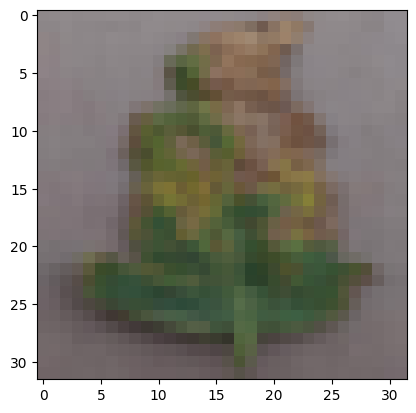

In [31]:
img, label = val_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:',
      predict_image(img, model))

Label: Early_blight , Predicted: Early_blight


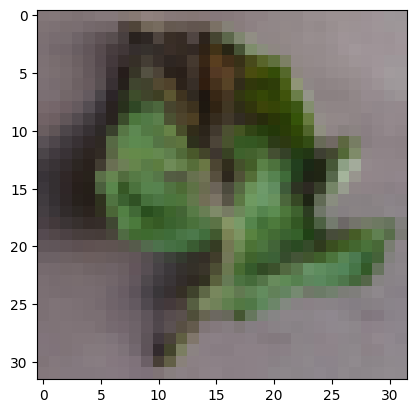

In [33]:
img, label = val_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_ds.classes[label], ', Predicted:', 
      predict_image(img, model))

In [34]:
torch.save(model.state_dict(), 'tomatoleaf_disease-resnet34.pth')